0. Выбрать любой подходящий датасет для классификации, например [digits dataset из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
или [MNIST из keras](https://keras.io/api/datasets/mnist/).
1. Реализовать однослойный перцептрон без использования библиотек.
   - Выбрать функцию активации, например, сигмоиду.
   - Реализовать прямой проход.
   - Вычислить ошибку.
   - Реализовать обратный проход, скорректировать веса НС.
   - Реализовать функцию обучения НС с параметром количества эпох (итераций).
   - Вывести метрики, построить сопутствующие графики.
2. Сравнить результаты с использованием [однослойного перцептрона из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html).
3. Сравнить результаты с использованием [многослойного перцептрона из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [2]:
import numpy as np
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print(X_train.shape, X_val.shape, X_test.shape)

(50000, 785) (10000, 785) (10000, 785)


In [41]:
class Perceptron(object):
    def __init__(self, D, C, std=1e-4):
        
        self.W1 = std * np.random.randn(D, C)
        self.C = C
        self.softmax = lambda x : np.exp(x)/np.tile(np.exp(x).sum(-1),(x.shape[1],1)).T
        # self.relu = lambda x : np.max((np.zeros_like(x),x),axis=0)
    
    def forward_pass(self, x):
        # x : (N,D)
        scores = x.dot(self.W1)
        cache = (x, self.W1)
        return scores, cache
    
    def loss(self, x, y):
        shifted_logits = x - np.max(x, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)
        N = x.shape[0]
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx
    
    def backward_pass(self, dout, cache):
        x, w = cache
        dx = dout.dot(w.T)
        dw = x.T.dot(dout)
        return dx, dw
    
    def train_step(self, w, dw, lr=1e-4):
        w -= lr*dw
        return w
    
    def train(self, X_train, y_train, epochs, batch_size = 200, lr=1e-4):
        self.loss_history = []
        iters = max(X_train.shape[0]//batch_size,1)
        for _ in range(epochs):
            for i in range(iters):
                rand_ind = np.random.choice(X_train.shape[0],batch_size)  
                X_batch = X_train[rand_ind]    
                y_batch = y_train[rand_ind]
                scores, cache = self.forward_pass(X_batch)
                loss, dout = self.loss(scores,y_batch)
                dout, grad = self.backward_pass(dout,cache)                
                self.W1 = self.train_step(self.W1,grad,lr)
                self.loss_history.append(loss)
        return self
    
    def predict(self, x):
        scores = self.forward_pass(x)
        y_pred = np.argmax(self.softmax(scores[0]), axis=1)        
        return y_pred

In [48]:
model = Perceptron(785,10)
model.train(X_train,y_train,epochs=5,lr=0.01)

0.8774


<AxesSubplot: >

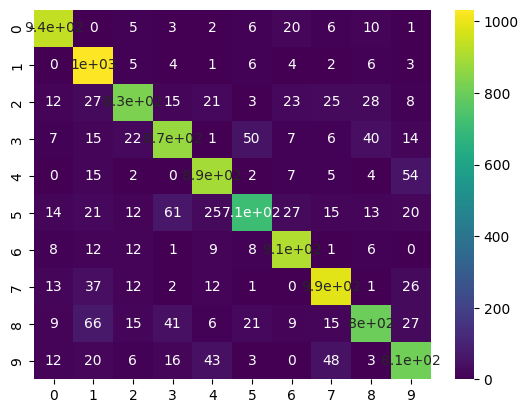

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val,model.predict(X_val)))
sns.heatmap(confusion_matrix(y_val,model.predict(X_val)),cmap = 'viridis', annot=True)

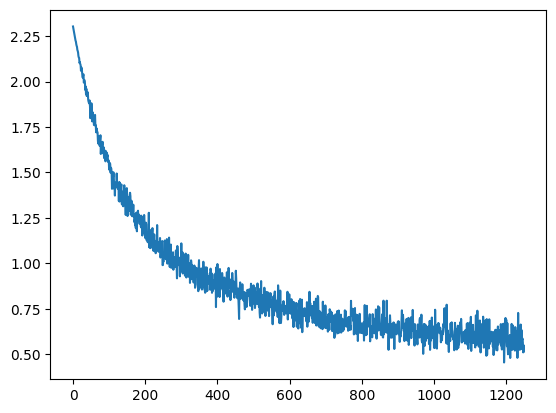

In [51]:
from matplotlib import pyplot as plt
plt.plot(model.loss_history)

In [52]:
from sklearn.linear_model import Perceptron as P

In [53]:
clf = P()
clf.fit(X_train, y_train)

Perceptron()

0.8879


<AxesSubplot: >

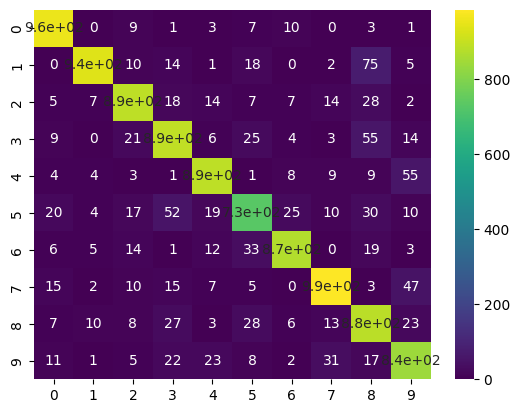

In [55]:
print(clf.score(X_val, y_val))
sns.heatmap(confusion_matrix(y_val,clf.predict(X_val)),cmap = 'viridis', annot=True)

In [57]:
from sklearn.neural_network import MLPClassifier

In [58]:
clf2 = MLPClassifier()
clf2.fit(X_train, y_train)

MLPClassifier()

0.9799


<AxesSubplot: >

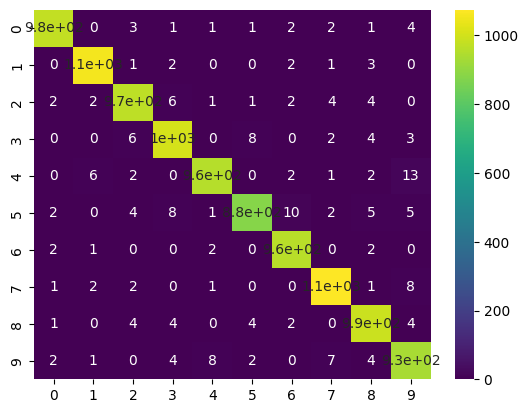

In [59]:
print(clf2.score(X_val, y_val))
sns.heatmap(confusion_matrix(y_val,clf2.predict(X_val)),cmap = 'viridis', annot=True)